The aim of this study is to determine whether movie metadata gathered from the MovieLens website (via Kaggle) can be utilized to predict the success of a movie as measured by its overall revenue using lasso regression. The project also employs k-means clustering to examine whether movie metadata can offer any insights into patterns that exist outside of movie genres for the purpose of grouping films online for recommenders or targeted advertising campaigns.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Data load, analysis, and cleaning

In [2]:
# Import the dataset
dataset = pd.read_csv('movies_metadata.csv')

# Examine columns of data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

C:\Users\jmp5118\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Examine first five rows of data
dataset.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# Create dataframe for selected data
num_cols = ['budget','popularity','revenue','runtime','vote_average','vote_count']
mov_df = dataset[['genres','title','budget','popularity','revenue','runtime','vote_average','vote_count']].copy()

In [5]:
# Find rows with non-numeric values and drop; convert cols to numeric dtype 
mov_data = (mov_df.drop(num_cols, axis=1)
         .join(mov_df[num_cols].apply(pd.to_numeric, errors='coerce')))

mov_data = mov_data[mov_data[num_cols].notnull().all(axis=1)]

In [6]:
# Insert calculated profit column
mov_data['profit'] = mov_data['revenue'] - mov_data['budget']
mov_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45203 entries, 0 to 45465
Data columns (total 9 columns):
genres          45203 non-null object
title           45203 non-null object
budget          45203 non-null float64
popularity      45203 non-null float64
revenue         45203 non-null float64
runtime         45203 non-null float64
vote_average    45203 non-null float64
vote_count      45203 non-null float64
profit          45203 non-null float64
dtypes: float64(7), object(2)
memory usage: 3.4+ MB


In [7]:
mov_data['genres'] = mov_data['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
mov_data.head()

,genres,title,budget,popularity,revenue,runtime,vote_average,vote_count,profit
0,"[Animation, Comedy, Family]",Toy Story,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,343554033.0
1,"[Adventure, Fantasy, Family]",Jumanji,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,197797249.0
2,"[Romance, Comedy]",Grumpier Old Men,0.0,11.712900,0.0,101.0,6.5,92.0,0.0
3,"[Comedy, Drama, Romance]",Waiting to Exhale,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,65452156.0
4,[Comedy],Father of the Bride Part II,0.0,8.387519,76578911.0,106.0,5.7,173.0,76578911.0


In [9]:
# Convert genres to binary matrix of 1/0 for modeling
# code attribution: https://github.com/gaurangdavda
s = mov_data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_rgf = mov_data.drop('genres', axis=1).join(s)
genres_train = gen_rgf['genre'].drop_duplicates()

for genre in genres_train:
        mov_data['is_' + str(genre)] = mov_data['genres'].apply(lambda x: 1 if genre in x else 0)
mov_data['genres'] = mov_data['genres'].apply(lambda x: len(x))

In [10]:
mov_data.head()

,genres,title,budget,popularity,revenue,runtime,vote_average,vote_count,profit,is_Animation,...,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_nan,is_Music,is_Documentary,is_Western,is_TV Movie
0,3,Toy Story,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,343554033.0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,Jumanji,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,197797249.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Grumpier Old Men,0.0,11.712900,0.0,101.0,6.5,92.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Waiting to Exhale,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,65452156.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Father of the Bride Part II,0.0,8.387519,76578911.0,106.0,5.7,173.0,76578911.0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# remove movies lacking data; focus on feature-length, bigger budget
mov_data = mov_data[mov_data.budget >= 100000]
mov_data = mov_data[mov_data.runtime > 60]
mov_data = mov_data[mov_data.revenue > 2000]
mov_data = mov_data[mov_data.vote_average > 0]

In [12]:
mov_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5241 entries, 0 to 45422
Data columns (total 30 columns):
genres                5241 non-null int64
title                 5241 non-null object
budget                5241 non-null float64
popularity            5241 non-null float64
revenue               5241 non-null float64
runtime               5241 non-null float64
vote_average          5241 non-null float64
vote_count            5241 non-null float64
profit                5241 non-null float64
is_Animation          5241 non-null int64
is_Comedy             5241 non-null int64
is_Family             5241 non-null int64
is_Adventure          5241 non-null int64
is_Fantasy            5241 non-null int64
is_Romance            5241 non-null int64
is_Drama              5241 non-null int64
is_Action             5241 non-null int64
is_Crime              5241 non-null int64
is_Thriller           5241 non-null int64
is_Horror             5241 non-null int64
is_History            5241 non-null i

## Lasso regression

In [13]:
# Create DF for regression model
reg_data = mov_data.drop(['is_nan','title','profit'], axis=1)
reg_data.columns

Index(['genres', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'is_Animation', 'is_Comedy', 'is_Family', 'is_Adventure',
       'is_Fantasy', 'is_Romance', 'is_Drama', 'is_Action', 'is_Crime',
       'is_Thriller', 'is_Horror', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_War', 'is_Foreign', 'is_Music', 'is_Documentary',
       'is_Western', 'is_TV Movie'],
      dtype='object')

In [14]:
# Rescale data so that all the features are approximately on the same scale
scaler = StandardScaler()
scaled = scaler.fit_transform(reg_data)

# Convert back from array to dataframe
data_scaled = pd.DataFrame(scaled, columns=reg_data.columns)

In [15]:
# split data into a training and test set:
X_scaled = data_scaled.drop(columns=['revenue'])
y_scaled = data_scaled[['revenue']]

# Split X and y into X_
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=1)

In [16]:
# Create lasso model
lasso = Lasso(alpha=.001, max_iter=1000, normalize=False).fit(X_train_scaled, y_train_scaled)

print("Lasso.coef_:", lasso.coef_)
print("Lasso.intercept_:", lasso.intercept_)
print("Lasso training set score: {:.2f}".format(lasso.score(X_train_scaled, y_train_scaled)))
print("Lasso test set score: {:.2f}".format(lasso.score(X_test_scaled, y_test_scaled)))
    
print("Number of features used:", np.sum(lasso.coef_ != 0))

Lasso.coef_: [-0.          0.39631924  0.0839708   0.04666591 -0.          0.49362944
  0.03053619  0.01552279  0.03574517  0.03435151  0.01167732  0.02757505
 -0.02768336 -0.00995936 -0.01969385 -0.0146953   0.01434514 -0.01355078
 -0.04405253 -0.00564264 -0.00879743  0.00133292  0.0108292   0.01138319
 -0.02357158  0.00475404]
Lasso.intercept_: [0.00189067]
Lasso training set score: 0.74
Lasso test set score: 0.65
Number of features used: 24


In [17]:
# print coefficients with feature names
for idx, col_name in enumerate(X_train_scaled.columns):
    print("The Lasso coefficient for {} is {}".format(col_name, lasso.coef_[idx]))
    
print("The Lasso intercept for our model is {}".format(lasso.intercept_))

The Lasso coefficient for genres is -0.0
The Lasso coefficient for budget is 0.3963192405592033
The Lasso coefficient for popularity is 0.0839708025881729
The Lasso coefficient for runtime is 0.0466659061236744
The Lasso coefficient for vote_average is -0.0
The Lasso coefficient for vote_count is 0.4936294384861946
The Lasso coefficient for is_Animation is 0.03053618599862236
The Lasso coefficient for is_Comedy is 0.015522787755250804
The Lasso coefficient for is_Family is 0.03574516654442649
The Lasso coefficient for is_Adventure is 0.0343515111453366
The Lasso coefficient for is_Fantasy is 0.011677317609206088
The Lasso coefficient for is_Romance is 0.02757504744513524
The Lasso coefficient for is_Drama is -0.027683357703140513
The Lasso coefficient for is_Action is -0.009959362917603602
The Lasso coefficient for is_Crime is -0.019693848788657816
The Lasso coefficient for is_Thriller is -0.014695297919068966
The Lasso coefficient for is_Horror is 0.014345142933208387
The Lasso coeffi

In [18]:
# calculate MSE
y_predict = lasso.predict(X_test_scaled)
lasso_model_mse = mean_squared_error(y_predict, y_test_scaled)
mseRoot = math.sqrt(lasso_model_mse)

print("Lasso MSE %s " % mseRoot)

Lasso MSE 0.4928057606369254 


## Clustering

In [19]:
# Note some variation in cluster data vs. paper, due to re-run of model after paper analysis. All settings and parameters are unchanged.
# Add profit to numeric columns list
num_cols.append('profit')

# Create DF for clustering model; exclude genres, which are obvious clusters on their own
cluster_data = mov_data[num_cols].copy()
cluster_data.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'profit'],
      dtype='object')

In [20]:
# Rescale data so that all the features are approximately on the same scale
c_scaler = StandardScaler()
c_scaled = scaler.fit_transform(cluster_data)

# Convert back from array to dataframe
c_data_scaled = pd.DataFrame(c_scaled, columns=cluster_data.columns)

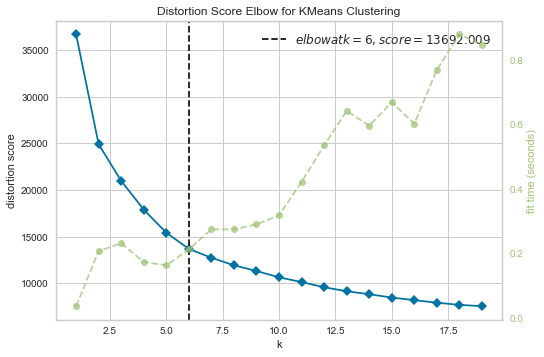

In [21]:
# determine number of k clusters using the Elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
X = np.array(c_data_scaled)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

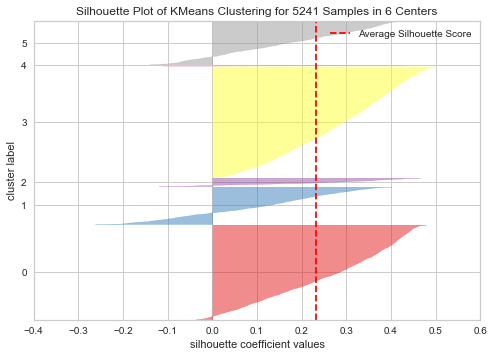

In [22]:
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [23]:
# check silhouette score
visualizer.silhouette_score_

0.2312137431026712

In [24]:
# Number of clusters
kmeans = KMeans(n_clusters=6)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

labels = kmeans.labels_

In [25]:
mov_data['cluster'] = labels
cluster_data['cluster'] = labels

In [26]:
mov_data.head()

,genres,title,budget,popularity,revenue,runtime,vote_average,vote_count,profit,is_Animation,...,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_nan,is_Music,is_Documentary,is_Western,is_TV Movie,cluster
0,3,Toy Story,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,343554033.0,1,...,0,0,0,0,0,0,0,0,0,1
1,3,Jumanji,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,197797249.0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,Waiting to Exhale,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,65452156.0,0,...,0,0,0,0,0,0,0,0,0,2
5,4,Heat,60000000.0,17.924927,187436818.0,170.0,7.7,1886.0,127436818.0,0,...,0,0,0,0,0,0,0,0,0,2
8,3,Sudden Death,35000000.0,5.231580,64350171.0,106.0,5.5,174.0,29350171.0,0,...,0,0,0,0,0,0,0,0,0,5


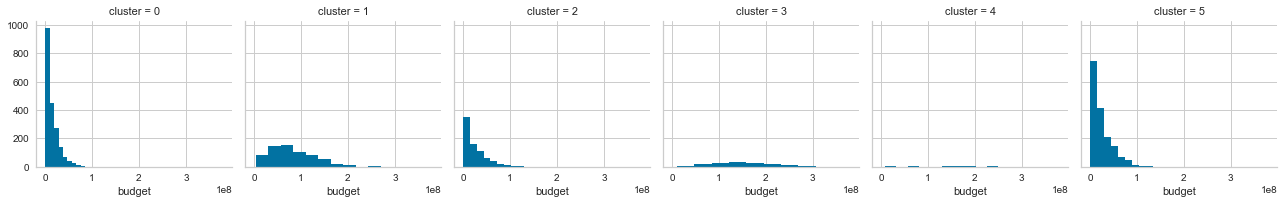

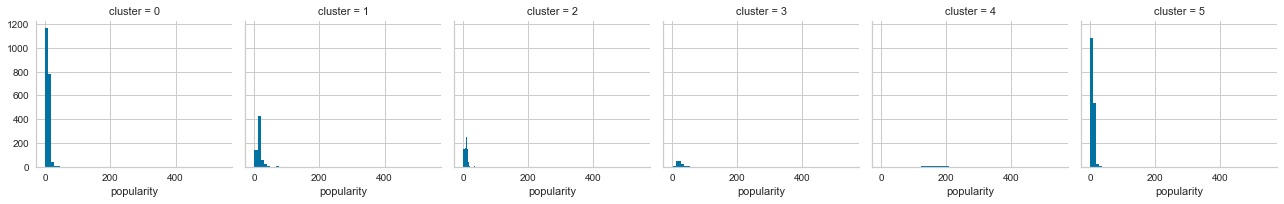

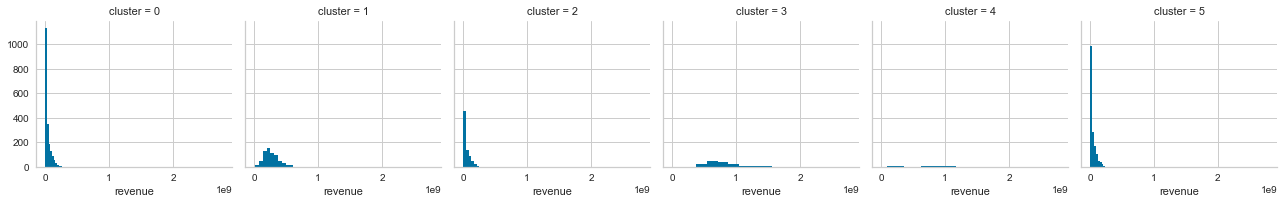

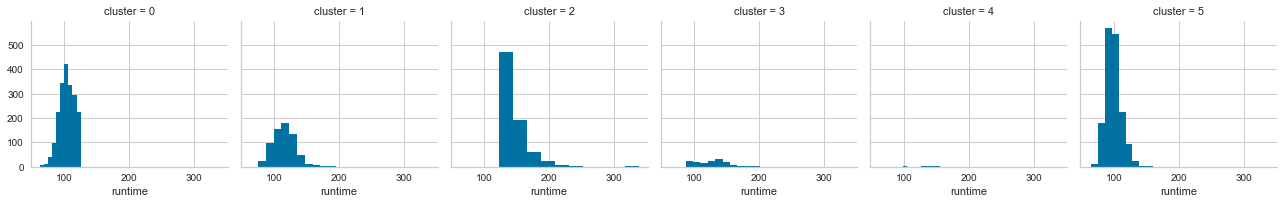

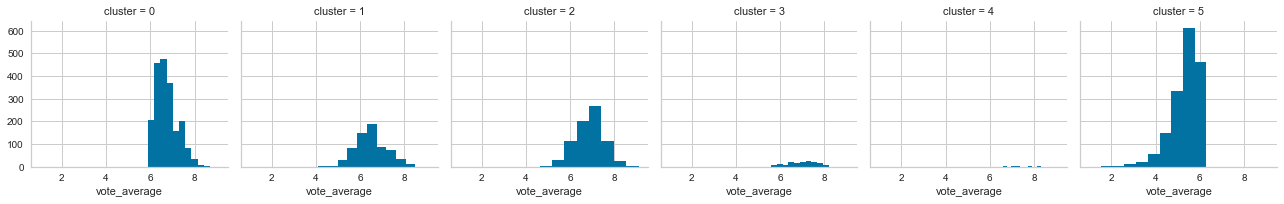

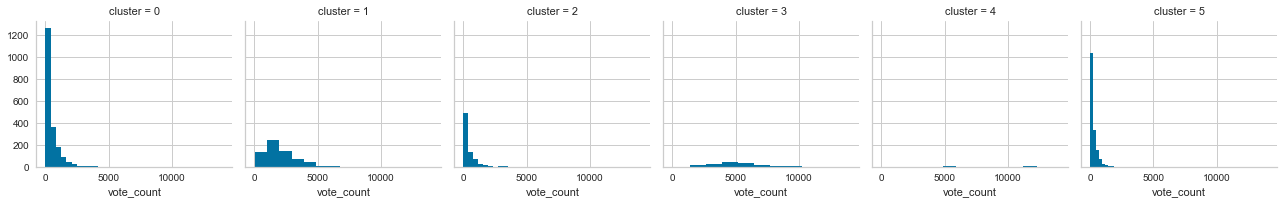

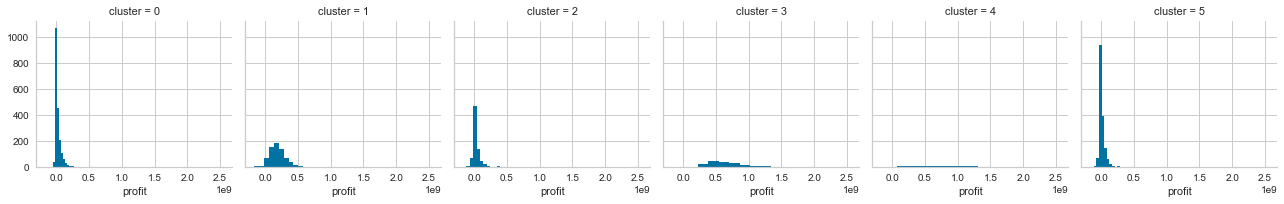

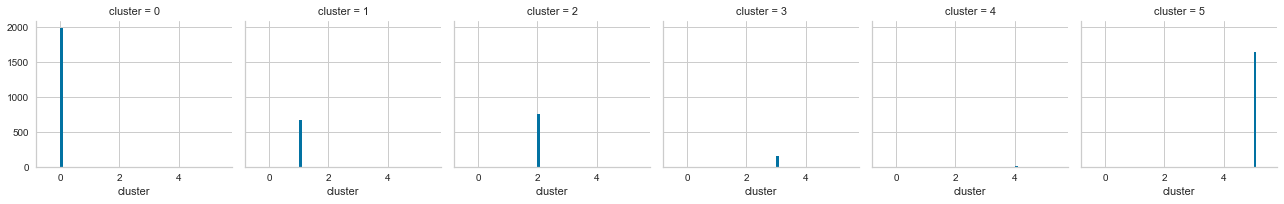

In [29]:
# Visualize resulting clusters
for cluster in cluster_data:
    grid = sns.FacetGrid(cluster_data, col='cluster')
    grid.map(plt.hist, cluster)

In [30]:
# Feature overview of clusters
cluster_means = pd.DataFrame(cluster_data.groupby(['cluster']).mean())
cluster_means.head(6)

,budget,popularity,revenue,runtime,vote_average,vote_count,profit
cluster,,,,,,,
0,1.435231e+07,8.470680,3.828456e+07,103.772431,6.730877,466.307268,2.393225e+07
1,8.154631e+07,14.883908,2.665846e+08,114.961019,6.471814,2051.809595,1.850383e+08
2,2.418778e+07,8.085015,5.072296e+07,144.329829,6.864915,426.542707,2.653518e+07
3,1.502910e+08,23.777244,7.807557e+08,128.006667,7.026000,5309.506667,6.304647e+08
4,1.317500e+08,206.561415,8.310870e+08,129.625000,7.256250,6390.687500,6.993370e+08
5,2.484293e+07,7.451255,3.749901e+07,99.044189,5.330690,245.437651,1.265609e+07


In [31]:
cluster_means.to_excel('cluster_means.xls')

In [32]:
# Examine size of each cluster
cluster_data['cluster'].value_counts()

0    1995
5    1652
2     761
1     667
3     150
4      16
Name: cluster, dtype: int64

In [33]:
# Comparing with scikit-learn centroids

print(centroids) # From sci-kit learn

[[-0.43312703 -0.10651388 -0.3234721  -0.30747193  0.49775708 -0.22462808
  -0.26061628]
 [ 1.22951755  0.35363611  1.03773792  0.21461904  0.20878906  1.03110346
   0.8819192 ]
 [-0.19223091 -0.13386439 -0.2491652   1.58935317  0.65278171 -0.25510625
  -0.24124921]
 [ 2.93159399  0.99136777  4.10396782  0.82413783  0.83173648  3.61017669
   4.04078538]
 [ 2.47253015 14.09862554  4.40411596  0.89974961  1.09055512  4.46613244
   4.52921295]
 [-0.17402751 -0.17926038 -0.32879136 -0.52926899 -1.07581608 -0.39904381
  -0.34115533]]
